### Backtesting with transaction fee, taxes and dividends

# 초기 조건 / 데이터 임포트 / 벤치마크 계산

## 라이브러리 임포트

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import pandas as pd
import numpy as np
from datetime import datetime
import math

In [3]:
current_date = datetime.now().strftime("%Y-%m-%d-%H-%M-%S")

## 데이터 임포트

In [4]:
spy_df = pd.read_csv('/content/drive/MyDrive/momentum-strategies/absolute_momentum/SPY.csv')[:-2] # 2021-09까지 결과 출력
closes = spy_df.Close.to_numpy()
opens = spy_df.Open.to_numpy()
spy_df['Date'] = spy_df['Date'].map(lambda x: x[:-3])

In [5]:
tb3_df = pd.read_csv('/content/drive/MyDrive/momentum-strategies/absolute_momentum/TB3MS.csv')
risk_free_rates = tb3_df.TB3MS.to_numpy() / 100

In [6]:
spy_dividend_df = pd.read_csv('/content/drive/MyDrive/momentum-strategies/absolute_momentum/SPY_dividends.csv')
spy_dividend_df['Date'] = spy_dividend_df['Date'].map(lambda x: x[:-3])
spy_dividend_df.sort_values(by=['Date'], inplace=True)

In [7]:
spy_dividend_df['Month'] = spy_dividend_df['Date'].map(lambda x: spy_df.index[spy_df['Date']==x].item())

In [8]:
spy_dividends = np.zeros(len(closes))
# 배당이 없는 달은 0으로 처리
for month, div in zip(spy_dividend_df.Month, spy_dividend_df.Dividends.map(lambda x: round(x,3))):
  spy_dividends[month] = div

# Backtesting

In [9]:
strategies = []
returns = []

In [10]:
class Portfolio:
  """
  A) strategies  
    1) backtest 2) buy_and_hold
  B) details in a strategy 
    1) init_portfolio 2) intra_month 3) signal_trading 4) save_result
  C) activities in a strategy
    1) buy 2) sell 3) sell_trade_gains 4) pay_tax 5) capital_gains_tax
  D) results
    1) mdd 2) annual_returns 3) monthly_returns 4) statistics
  """

  def __init__(self, benchmark_df, risk_free_rates, benchmark_dividends, portfolio_config, buy_and_hold=False):
    """
    ex) portfolio_config = {"initial_cash":10000, "benchmark_name":"SPY", "rebalancing_period":6,"look_back":12, "exclude_period":0, "start_month":4,"tax_rate":0.22, "fee_rate":0.0025, "tax_threshold": 2500000 / 1100}
    """
    self.benchmark_opens = benchmark_df.Open.to_numpy()
    self.benchmark_closes = benchmark_df.Close.to_numpy()
    self.benchmark_highs = benchmark_df.High.to_numpy()
    self.benchmark_lows = benchmark_df.Low.to_numpy()
    self.benchmark_dates = benchmark_df.Date.to_numpy()
    self.risk_free_rates = risk_free_rates
    if len(benchmark_dividends):
      self.benchmark_dividends = benchmark_dividends
      apply_dividends = True
    else:
      self.benchmark_dividends = np.zeros(len(self.benchmark_dates))
      apply_dividends = False
    for key, value in portfolio_config.items():
      setattr(self, key, value)
    self.columns = ["upwards", "cash", "investments", "shares", "buy_prices", "fees", "divs", "month_gains", "annual_gains", "annual_taxes", "portfolio_closes", "portfolio_opens", "portfolio_highs", "portfolio_lows"]
    for column in self.columns:
      setattr(self, column, np.zeros(len(self.benchmark_dates)))
    self.stats = ['accum_fees', 'accum_taxes', 'accum_divs', 'buy_counts', 'sell_counts', 'long_position']
    for stat in self.stats:
      setattr(self, stat, 0)
    self.div_tax_rate = 0.15
    self.df = pd.DataFrame({'date': self.benchmark_dates, 'opens': self.benchmark_opens, 'closes': self.benchmark_closes, 'highs':self.benchmark_highs, 'lows':self.benchmark_lows})
    portfolio_name = "benchmark_b&h" if buy_and_hold else f"{self.benchmark_name}_{self.rebalancing_period}:{self.look_back}_{self.start_month}to{(self.start_month + self.rebalancing_period) % 12}ex{self.exclude_period}"
    self.name = portfolio_name + f"{'_tax' if self.tax_rate > 0 else ''}{'_fee' if self.fee_rate > 0 else ''}{'_div' if apply_dividends else ''}"

  """A) strategies"""
  def backtest(self):
    trade_month_index = (self.start_month - int(self.benchmark_dates[0][-2:])) % self.rebalancing_period
    while trade_month_index < 0:
      # ex) self.rebalancing_period == 1, trade_month_index == -7 -> trade_month_index becomes 0 
      # ex) self.rebalancing_period == 6, trade_month_index == -1 -> trade_month_index becomes 5 
      trade_month_index += self.rebalancing_period 
    tax_month_index = (12 - int(self.benchmark_dates[0][-2:])) % 12
    self.init_portfolio(self.look_back)
    # self.look_back 시점 이후 거래 시작
    for i in range(self.look_back, len(self.benchmark_dates)):
      # 월말 거래 전
      self.intra_month(i)
      # trade
      self.signal_trading(i, trade_month_index)
      # tax
      if (i % 12 == tax_month_index):
        self.capital_gains_tax(i)
      self.accum_taxes += self.annual_taxes[i]
      # fees
      self.accum_fees += self.fees[i]
      self.accum_divs += self.divs[i]
    self.save_to_df()
    strategies.append(self.statistics())
    returns.append({"name":self.name, "df":self.df['portfolio_closes'].to_numpy()})

  def buy_and_hold(self, start):
    self.init_portfolio(start)
    for i in range(start, len(self.benchmark_dates)):
      if i == 0:
        self.init_portfolio(1)
      else:
        self.intra_month(i)
      shares_plus = self.cash[i] / (1 + self.fee_rate) // self.benchmark_closes[i]
      self.buy(i, shares_plus)
      self.portfolio_closes[i] = self.shares[i] * self.benchmark_closes[i] + self.cash[i]
      # fees
      self.accum_fees += self.fees[i]
      self.accum_divs += self.divs[i]
    self.save_to_df()
    strategies.append(self.statistics())
    returns.append({"name":self.name, "df":self.df['portfolio_closes'].to_numpy()})

  """B) details in a strategy"""
  def init_portfolio(self, init_period):
    self.cash[0:init_period] = self.initial_cash
    self.portfolio_opens[0:init_period] = self.initial_cash
    self.portfolio_closes[0:init_period] = self.initial_cash
    self.portfolio_highs[0:init_period] = self.initial_cash
    self.portfolio_lows[0:init_period] = self.initial_cash
  
  def intra_month(self, i):
    current_dividend = self.benchmark_dividends[i] * self.shares[i-1] * (1 - self.div_tax_rate)
    self.cash[i] = self.cash[i-1] + current_dividend
    self.divs[i] = current_dividend
    self.shares[i] = self.shares[i-1]
    if self.shares[i] > 0:
      self.long_position += 1
    self.portfolio_opens[i] = self.shares[i] * self.benchmark_opens[i] + self.cash[i]
    self.portfolio_highs[i] = self.shares[i] * self.benchmark_highs[i] + self.cash[i]
    self.portfolio_lows[i] = self.shares[i] * self.benchmark_lows[i] + self.cash[i]
    self.investments[i] = self.shares[i] * self.benchmark_closes[i]
    self.buy_prices[i] = self.buy_prices[i-1]

  def signal_trading(self, i, trade_month_index):
    # trade with upwards signal
    if i % self.rebalancing_period == trade_month_index:
      self.upwards[i] = 1 if (self.benchmark_closes[i-self.exclude_period] - self.benchmark_closes[i-self.look_back]) / self.benchmark_closes[i-self.look_back] >= self.risk_free_rates[i] else 0
      previus_i = i - self.rebalancing_period
      while previus_i < 0:
        previus_i += 1
      if self.upwards[i] == 1:
        # 0 - 1 (신규 매수) / 1 - 1 (추가 매수)
        shares_plus = self.cash[i] / (1 + self.fee_rate) // self.benchmark_closes[i]
        self.buy(i, shares_plus)
      elif self.upwards[previus_i] == 1 and self.upwards[i] == 0:
        # 1 - 0 (전량 매도)
        self.sell(i, self.shares[i])
    self.portfolio_closes[i] = self.shares[i] * self.benchmark_closes[i] + self.cash[i]

  def save_to_df(self):
    self.df['benchmark_closes'] = self.benchmark_closes.tolist()
    for column in self.columns:
      self.df[column] = getattr(self, column).tolist()
    # self.df.to_csv(f'/content/drive/MyDrive/quant_projects/momentum_strategies/{current_date}_{self.name}.csv')

  """C) activities in a strategy"""
  def buy(self, i, buy_shares):
    self.shares[i] += buy_shares
    buy_amount = buy_shares * self.benchmark_closes[i]
    self.investments[i] += buy_amount
    self.cash[i] -= buy_amount * (1 + self.fee_rate)
    self.fees[i] += buy_amount * self.fee_rate
    self.buy_prices[i] = (self.buy_prices[i-1] * self.shares[i-1] + buy_amount) / self.shares[i] 
    if buy_shares > 0:
      self.buy_counts += 1

  def sell(self, i, sell_shares):
    self.shares[i] -= sell_shares
    sell_amount = sell_shares * self.benchmark_closes[i]
    self.investments[i] -= sell_amount
    self.cash[i] += sell_amount * (1 - self.fee_rate)
    self.fees[i] += sell_amount * self.fee_rate
    self.buy_prices[i] = 0 if self.shares[i] == 0 else self.buy_prices[i-1]
    self.month_gains[i] += self.sell_trade_gains(i, sell_shares)
    if sell_shares > 0:
      self.sell_counts += 1

  def sell_trade_gains(self, i, sell_shares):
    # returns expected_trade_gains (양도수익 - 매매대금 수수료)
    return (sell_shares * (self.benchmark_closes[i] - self.buy_prices[i-1]) - sell_shares * self.benchmark_closes[i] * self.fee_rate)

  def pay_tax(self, i, current_tax):
    # 올해 세금 확정 후 납부
    self.annual_taxes[i] = current_tax
    self.cash[i] -= current_tax

  def capital_gains_tax(self, i):
    self.annual_gains[i] = sum(self.month_gains[i-11:i+1])
    if self.annual_gains[i] > self.tax_threshold:
      # 1)세금을 내야 하는 경우
      current_tax = (self.annual_gains[i] - self.tax_threshold) * self.tax_rate
      if self.cash[i] >= current_tax:
        # 1-1)보유현금이 세금보다 많은 경우
        self.pay_tax(i, current_tax)
      else:
        # 1-2)추가로 매도하여 세금을 내야하는 경우
        shares_minus = math.ceil((current_tax - self.cash[i]) / (1 - self.fee_rate) / self.benchmark_closes[i])
        trade_gains = self.sell_trade_gains(i, shares_minus)
        if (self.annual_gains[i] + trade_gains > self.tax_threshold):
          # 1-2-A)세금을 내기 위해 매도했는데 1-2-A1)확정 수익이 추가로 발생하거나 / 1-2-A2)확정 손실이 작아 세금을 내야 하는 경우
          if trade_gains > 0:
            # 1-2-A1)확정 수익이 추가로 발생 -> 추가분까지 고려하여 매도수량 계산
            shares_minus = math.ceil(((self.annual_gains[i] - self.tax_threshold) * self.tax_rate - self.cash[i]) / (1 - self.fee_rate) / (self.benchmark_closes[i] * (1 - self.tax_rate) + self.buy_prices[i-1] * self.tax_rate))
            trade_gains = self.sell_trade_gains(i, shares_minus)
          # 매도 후 양도수익 업데이트
          self.sell(i, shares_minus)
          self.annual_gains[i] += trade_gains
          # 세금 업데이트 후 납부
          current_tax = (self.annual_gains[i] - self.tax_threshold) * self.tax_rate
          self.pay_tax(i, current_tax)
        else:
          # 1-2-B)세금을 내기 위해 매도했는데 세금보다 확정 손실이 커서 세금을 내지 않아도 되는 경우
          # 매도 후 양도수익 업데이트
          self.sell(i, shares_minus)
          self.annual_gains[i] += trade_gains
  
  """D) results"""
  def mdd(self):
    peak_lower = np.argmax(np.maximum.accumulate(self.portfolio_closes) - self.portfolio_closes)
    if peak_lower == 0:
      peak_upper = 0
    else:
      peak_upper = np.argmax(self.portfolio_closes[:peak_lower])
    # 월중 mdd
    # peak_lower = np.argmax((np.maximum.accumulate(self.portfolio_highs) - self.portfolio_lows) / np.maximum.accumulate(self.portfolio_highs))
    # peak_upper = np.argmax(self.portfolio_highs[:peak_lower])
    # print(peak_upper, peak_lower, (self.portfolio_lows[peak_lower] - self.portfolio_highs[peak_upper]) / self.portfolio_highs[peak_upper])
    return (self.portfolio_closes[peak_lower] - self.portfolio_closes[peak_upper]) / self.portfolio_closes[peak_upper]

  def annual_returns(self):
    month_lag = int(self.benchmark_dates[0][-2:]) - 1
    annual_returns = []
    for i in range(len(self.portfolio_closes) // 12 +1):
      if (i+1)*12 > len(self.portfolio_closes):
        annual_returns.append(round((self.portfolio_closes[-1] - self.portfolio_opens[i*12-month_lag]) / self.portfolio_opens[i*12-month_lag],4))
      elif i*12-month_lag < 0:
        annual_returns.append(round((self.portfolio_closes[i*12+11-month_lag] - self.portfolio_opens[0]) / self.portfolio_opens[0], 4))
      else:
        annual_returns.append(round((self.portfolio_closes[i*12+11-month_lag] - self.portfolio_opens[i*12-month_lag]) / self.portfolio_opens[i*12-month_lag],4))
    return annual_returns

  def monthly_returns(self):
    return[round((self.portfolio_closes[i] - self.portfolio_opens[i]) / self.portfolio_opens[i], 4) for i in range(len(self.benchmark_dates))]

  def statistics(self, annualize=True, is_average=False):
    time_series_returns = self.annual_returns() if annualize else self.monthly_returns()
    mean_risk_free_rate = np.mean(self.risk_free_rates) if is_average else 0.005
    cagr = round(pow(self.portfolio_closes[-1] / self.portfolio_closes[0], 1 / len(time_series_returns)) - 1, 4)
    mean_return = round(np.mean(time_series_returns),4)
    stddev = round(np.std(time_series_returns),4)
    sharpe = round((np.mean(time_series_returns)- mean_risk_free_rate) / np.std(time_series_returns),4)
    worst_time_series = round(min(time_series_returns), 4)
    best_time_series = round(max(time_series_returns), 4)
    mdd = round(self.mdd(), 4)
    statistics_dict = {
      'name':self.name, 
      'initial_balance': round(self.portfolio_closes[0], 2), 
      'final_balance':round(self.portfolio_closes[-1],2), 
      'cagr_annual':cagr, 
      'mean_annual':mean_return, 
      'stddev':stddev, 
      'sharpe':sharpe, 
      'worst_year':worst_time_series, 
      'best_year': best_time_series, 
      'mdd': mdd, 
      'accum_fees':round(self.accum_fees, 2), 
      'accum_taxes':round(self.accum_taxes, 2),
      'accum_divs':round(self.accum_divs, 2),
      'buy_counts': self.buy_counts,
      'sell_counts': self.sell_counts,
      'long_position': self.long_position
    }
    if not annualize:
      statistics_dict['cagr_monthly'] = statistics_dict.pop('cagr_annual')
      statistics_dict['mean_monthly'] = statistics_dict.pop('mean_annual')
    return statistics_dict

In [11]:
# 단일 건 테스트
# portfolio_config = {"initial_cash":10000, "benchmark_name":"SPY", "rebalancing_period":6,"look_back":12, "exclude_period":0, "start_month":4, "tax_rate":0.22, "fee_rate":0.0025, "tax_threshold": 2500000 / 1100}
# portfolio = Portfolio(df, risk_free_rates, dividends, portfolio_config)
# portfolio.backtest()

In [12]:
bnh_config = {"initial_cash":10000, "benchmark_name":"SPY", "tax_rate":0.22, "fee_rate":0.0025, "tax_threshold": 2500000 / 1100}
benchmark_bnh = Portfolio(spy_df, risk_free_rates, spy_dividends, bnh_config, buy_and_hold=True)
benchmark_bnh.buy_and_hold(start=0)

In [13]:
benchmark_bnh.statistics()

{'accum_divs': 20145.5,
 'accum_fees': 74.14,
 'accum_taxes': 0,
 'best_year': 0.3702,
 'buy_counts': 105,
 'cagr_annual': 0.0982,
 'final_balance': 151042.28,
 'initial_balance': 9975.13,
 'long_position': 343,
 'mdd': -0.5095,
 'mean_annual': 0.1087,
 'name': 'benchmark_b&h_tax_fee_div',
 'sell_counts': 0,
 'sharpe': 0.6152,
 'stddev': 0.1686,
 'worst_year': -0.3712}

In [14]:
rebalancing_periods = [1,3,6,12]
look_backs = [6,12]
for rebalancing_period in rebalancing_periods:
  for look_back in look_backs:
    for index in range(rebalancing_period):
      for exclude_period in range(min(3, look_back)):
        portfolio_details = {"initial_cash":10000, "benchmark_name":"SPY", "rebalancing_period":rebalancing_period,"look_back":look_back, "exclude_period":exclude_period, "start_month":2+index,"tax_rate":0.22, "fee_rate":0.0025, "tax_threshold": 2500000 / 1100}
        portfolio = Portfolio(spy_df, risk_free_rates, spy_dividends, portfolio_details)
        portfolio.backtest()

# 결과 출력

## statistics / returns csv 출력

In [15]:
statistics_df = pd.DataFrame(strategies)

In [16]:
statistics_df.sort_values(by=['cagr_annual'], inplace=True, ascending=False)

In [17]:
statistics_df

,name,initial_balance,final_balance,cagr_annual,mean_annual,stddev,sharpe,worst_year,best_year,mdd,accum_fees,accum_taxes,accum_divs,buy_counts,sell_counts,long_position
0,benchmark_b&h_tax_fee_div,9975.13,151042.28,0.0982,0.1087,0.1686,0.6152,-0.3712,0.3702,-0.5095,74.14,0.00,20145.50,105,0,343
51,SPY_6:12_4to10ex2_tax_fee_div,10000.00,141240.31,0.0956,0.1082,0.1150,0.8969,-0.1016,0.3272,-0.1944,905.93,11956.53,16079.64,43,6,257
105,SPY_12:12_4to4ex2_tax_fee_div,10000.00,128595.49,0.0921,0.1056,0.1206,0.8344,-0.0544,0.3664,-0.1932,756.46,11564.10,15547.19,21,3,245
49,SPY_6:12_4to10ex0_tax_fee_div,10000.00,127470.41,0.0917,0.1058,0.1114,0.9050,-0.0547,0.3272,-0.1942,1286.04,17546.80,16643.55,42,6,251
109,SPY_12:12_6to6ex0_tax_fee_div,10000.00,126390.93,0.0914,0.0996,0.1248,0.7578,-0.1199,0.3259,-0.1938,296.59,2310.82,14147.30,22,2,255
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15,SPY_3:6_4to7ex2_tax_fee_div,10000.00,34442.44,0.0436,0.0513,0.1100,0.4212,-0.2345,0.2920,-0.2301,1849.14,2148.69,4530.66,42,23,191
25,SPY_6:6_2to8ex0_tax_fee_div,10000.00,33023.58,0.0421,0.0486,0.1117,0.3900,-0.2009,0.2916,-0.1614,1164.20,1661.69,4533.25,28,15,199
2,SPY_1:6_2to3ex1_tax_fee_div,10000.00,32121.86,0.0411,0.0559,0.1124,0.4525,-0.1396,0.3215,-0.3477,3112.19,9520.70,5757.79,64,32,203
11,SPY_3:6_3to6ex1_tax_fee_div,10000.00,23156.39,0.0294,0.0609,0.1303,0.4289,-0.1373,0.3219,-0.4183,1443.70,13260.47,5153.46,43,21,216


In [18]:
statistics_df.to_csv(f'/content/drive/MyDrive/momentum-strategies/absolute_momentum/{current_date}_statistics.csv')

In [19]:
highlights = [0] + statistics_df.index.to_list()[:5] + statistics_df.index.to_list()[-5:]
highlights = list(set(highlights))

In [20]:
returns_df, highlights_df = [pd.DataFrame({'Date': spy_df['Date']}) for _ in range(2)]
for index in highlights:
  target_portfolio = returns[index]
  highlights_df[target_portfolio['name']] = target_portfolio['df']
for portfolio in returns:
  returns_df[portfolio['name']] = portfolio['df']
returns_df.to_csv(f'/content/drive/MyDrive/momentum-strategies/absolute_momentum/{current_date}_returns.csv')

## 그래프 출력

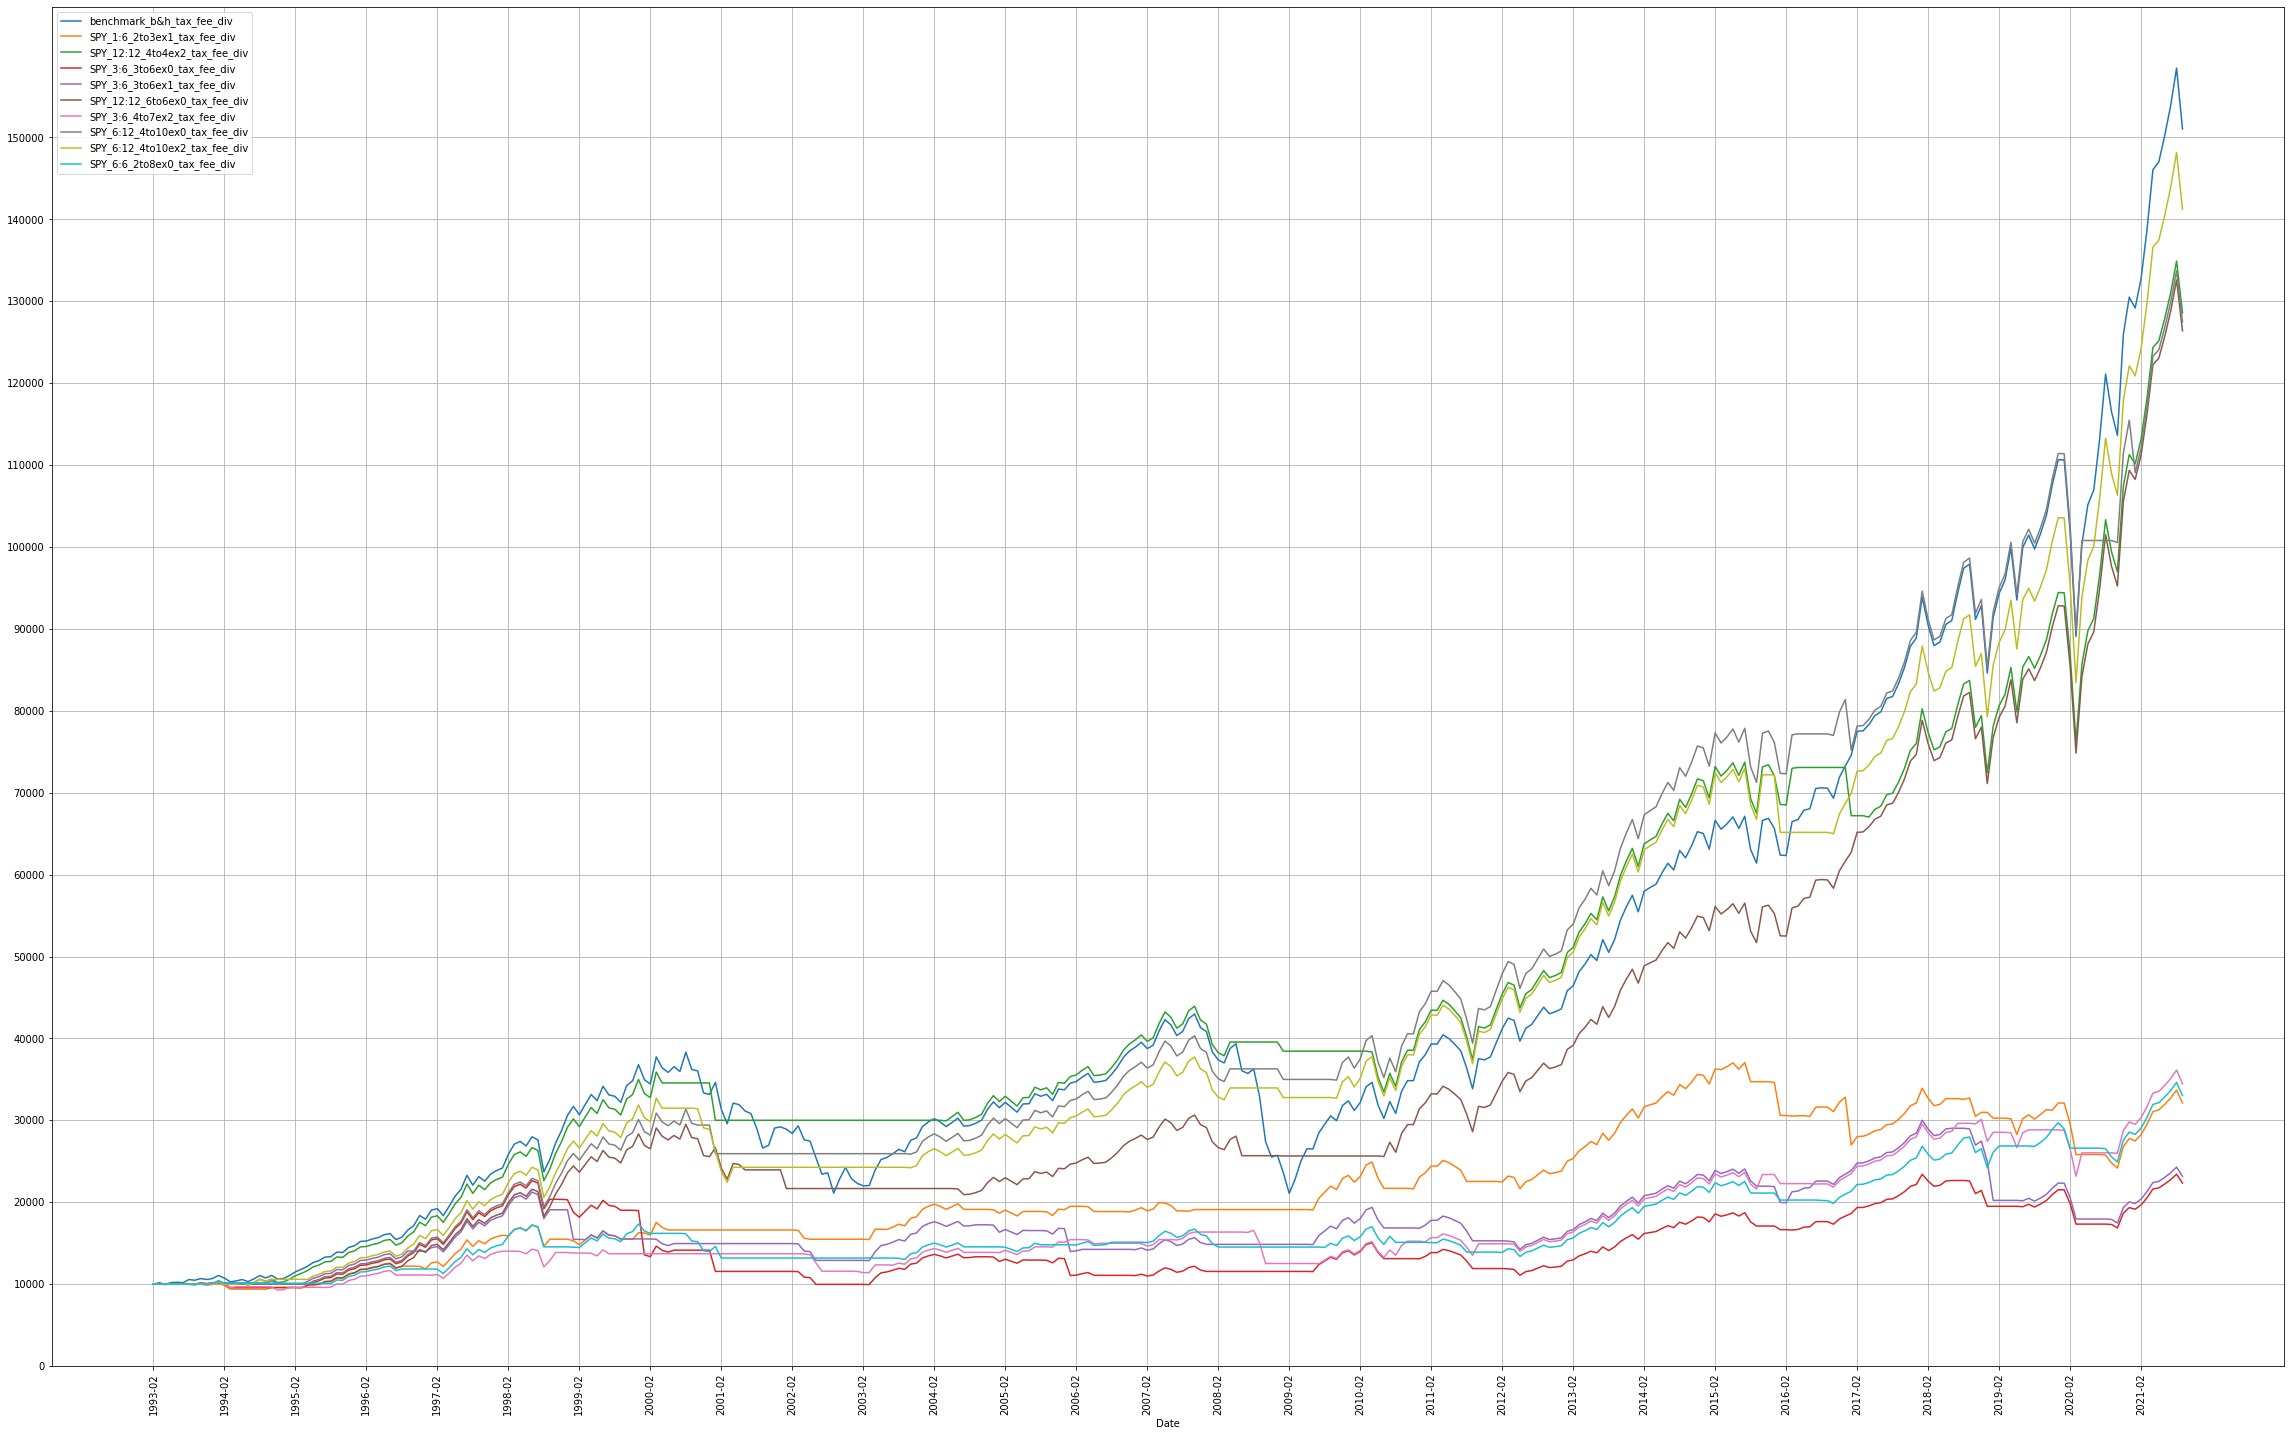

In [21]:
chart = highlights_df.plot.line(x='Date', grid=True, figsize=(40,25), xticks=np.arange(0, 346, 12), yticks=np.arange(0, 160000, 10000))
chart.tick_params(axis='x', rotation=90)
chart.figure.savefig(f'/content/drive/MyDrive/momentum-strategies/absolute_momentum/{current_date}_returns_highlights.jpg')